In [1]:
!pip install transformers datasets torch accelerate psutil wandb
!wandb login

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install transformers datasets torch

In [3]:
import torch
import wandb
import time
import psutil
import numpy as np
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TrainingArguments, Trainer
from datasets import load_dataset

In [4]:
wandb.init(project="gpt2-memory-comparison")

wandb: Currently logged in as: challengef0802 (songyeog) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [5]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [6]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

기본 모델 로드 - FP32

In [7]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

토큰 처리

In [8]:
def tokenize(examples):
    result = tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=128
    )
    result['labels'] = result['input_ids'].copy()
    return result

In [9]:
tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'labels']
)

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

In [10]:
def get_memory_usage():
    return psutil.Process().memory_info().rss / 1024 / 1024

이제 Baseline으로 FP32를 학습한다.

In [11]:
training_args = TrainingArguments(
    output_dir="./gpt2-fp32",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    save_steps=10_000,
    logging_steps=100,
    report_to="wandb",
    run_name="gpt2-fp32"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

start_time = time.time()
initial_memory = get_memory_usage()

trainer.train()

end_time = time.time()
final_memory = get_memory_usage()

wandb.log({"Training Time (FP32)": end_time - start_time, "Memory Usage (FP32)": final_memory - initial_memory})
print(f"Training time (FP32): {end_time - start_time:.2f} seconds")
print(f"Memory usage (FP32): {final_memory - initial_memory:.2f} MB")


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,1.487500
200,1.334900
300,1.378300
400,1.376400
500,1.260800
600,1.327300
700,1.460700
800,1.308600
900,1.293000
1000,1.228800


Training time (FP32): 323.29 seconds
Memory usage (FP32): 406.79 MB


# MixedPrecision

With FP16

In [12]:
training_args = TrainingArguments(
    output_dir="./gpt2-fp16",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    fp16=True,  # FP16!!!
    save_steps=10_000,
    logging_steps=100,
    report_to="wandb",
    run_name="gpt2-fp16"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

start_time = time.time()
initial_memory = get_memory_usage()

trainer.train()

end_time = time.time()
final_memory = get_memory_usage()

wandb.log({"Training Time (FP16)": end_time - start_time, "Memory Usage (FP16)": final_memory - initial_memory})
print(f"Training time (FP16): {end_time - start_time:.2f} seconds")
print(f"Memory usage (FP16): {final_memory - initial_memory:.2f} MB")

Step,Training Loss
100,1.061700
200,1.072600
300,1.115700
400,1.108900
500,1.024800
600,1.087400
700,1.217400
800,1.099600
900,1.098200
1000,1.041100


Training time (FP16): 211.49 seconds
Memory usage (FP16): 213.22 MB


BF16 학습 (NVIDIA Ampere 이상 GPU)


In [13]:
training_args = TrainingArguments(
    output_dir="./gpt2-bf16",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    bf16=True,  # BF16!!
    save_steps=10_000,
    logging_steps=100,
    report_to="wandb",
    run_name="gpt2-bf16"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

start_time = time.time()
initial_memory = get_memory_usage()

trainer.train()

end_time = time.time()
final_memory = get_memory_usage()

wandb.log({"Training Time (BF16)": end_time - start_time, "Memory Usage (BF16)": final_memory - initial_memory})
print(f"Training time (BF16): {end_time - start_time:.2f} seconds")
print(f"Memory usage (BF16): {final_memory - initial_memory:.2f} MB")


Step,Training Loss
100,1.239300
200,1.178600
300,1.181200
400,1.164400
500,1.076700
600,1.140000
700,1.279600
800,1.154600
900,1.149800
1000,1.092600


Training time (BF16): 209.37 seconds
Memory usage (BF16): 9.32 MB


TF32 학습 (NVIDIA Ampere 이상 GPU)

In [14]:
# TF32 문서러럼 활성화 해 줌
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

training_args = TrainingArguments(
    output_dir="./gpt2-tf32",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    tf32=True,  # TF32!!
    save_steps=10_000,
    logging_steps=100,
    report_to="wandb",
    run_name="gpt2-tf32"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

start_time = time.time()
initial_memory = get_memory_usage()

trainer.train()

end_time = time.time()
final_memory = get_memory_usage()

wandb.log({"Training Time (TF32)": end_time - start_time, "Memory Usage (TF32)": final_memory - initial_memory})
print(f"Training time (TF32): {end_time - start_time:.2f} seconds")
print(f"Memory usage (TF32): {final_memory - initial_memory:.2f} MB")


Step,Training Loss
100,0.980400
200,0.963800
300,0.984200
400,0.962500
500,0.882100
600,0.935500
700,1.051500
800,0.950900
900,0.949500
1000,0.899000


Training time (TF32): 210.14 seconds
Memory usage (TF32): 9.54 MB


In [15]:
wandb.finish()

Memory Usage (BF16),▁
Memory Usage (FP16),▁
Memory Usage (FP32),▁
Memory Usage (TF32),▁
Training Time (BF16),▁
Training Time (FP16),▁
Training Time (FP32),▁
Training Time (TF32),▁
train/epoch,▂▂▃▄▄▆▆▇▇█▂▂▂▂▃▅█▁▂▂▃▄▅▅▆▆▇█▂▃▄▅▅▆▆▆▆▇▇█
train/global_step,▁▁▂▂▃▅▅▇▇█▁▂▃▄▅▆▇▇▂▂▄▆▆▆▇██▁▁▂▂▃▃▃▄▅▆▇▇█
train/grad_norm,▁▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▆▆█▅▇▇▇█▇▆▇▅▄▆▅▄▆▅▇▄▇▆▅


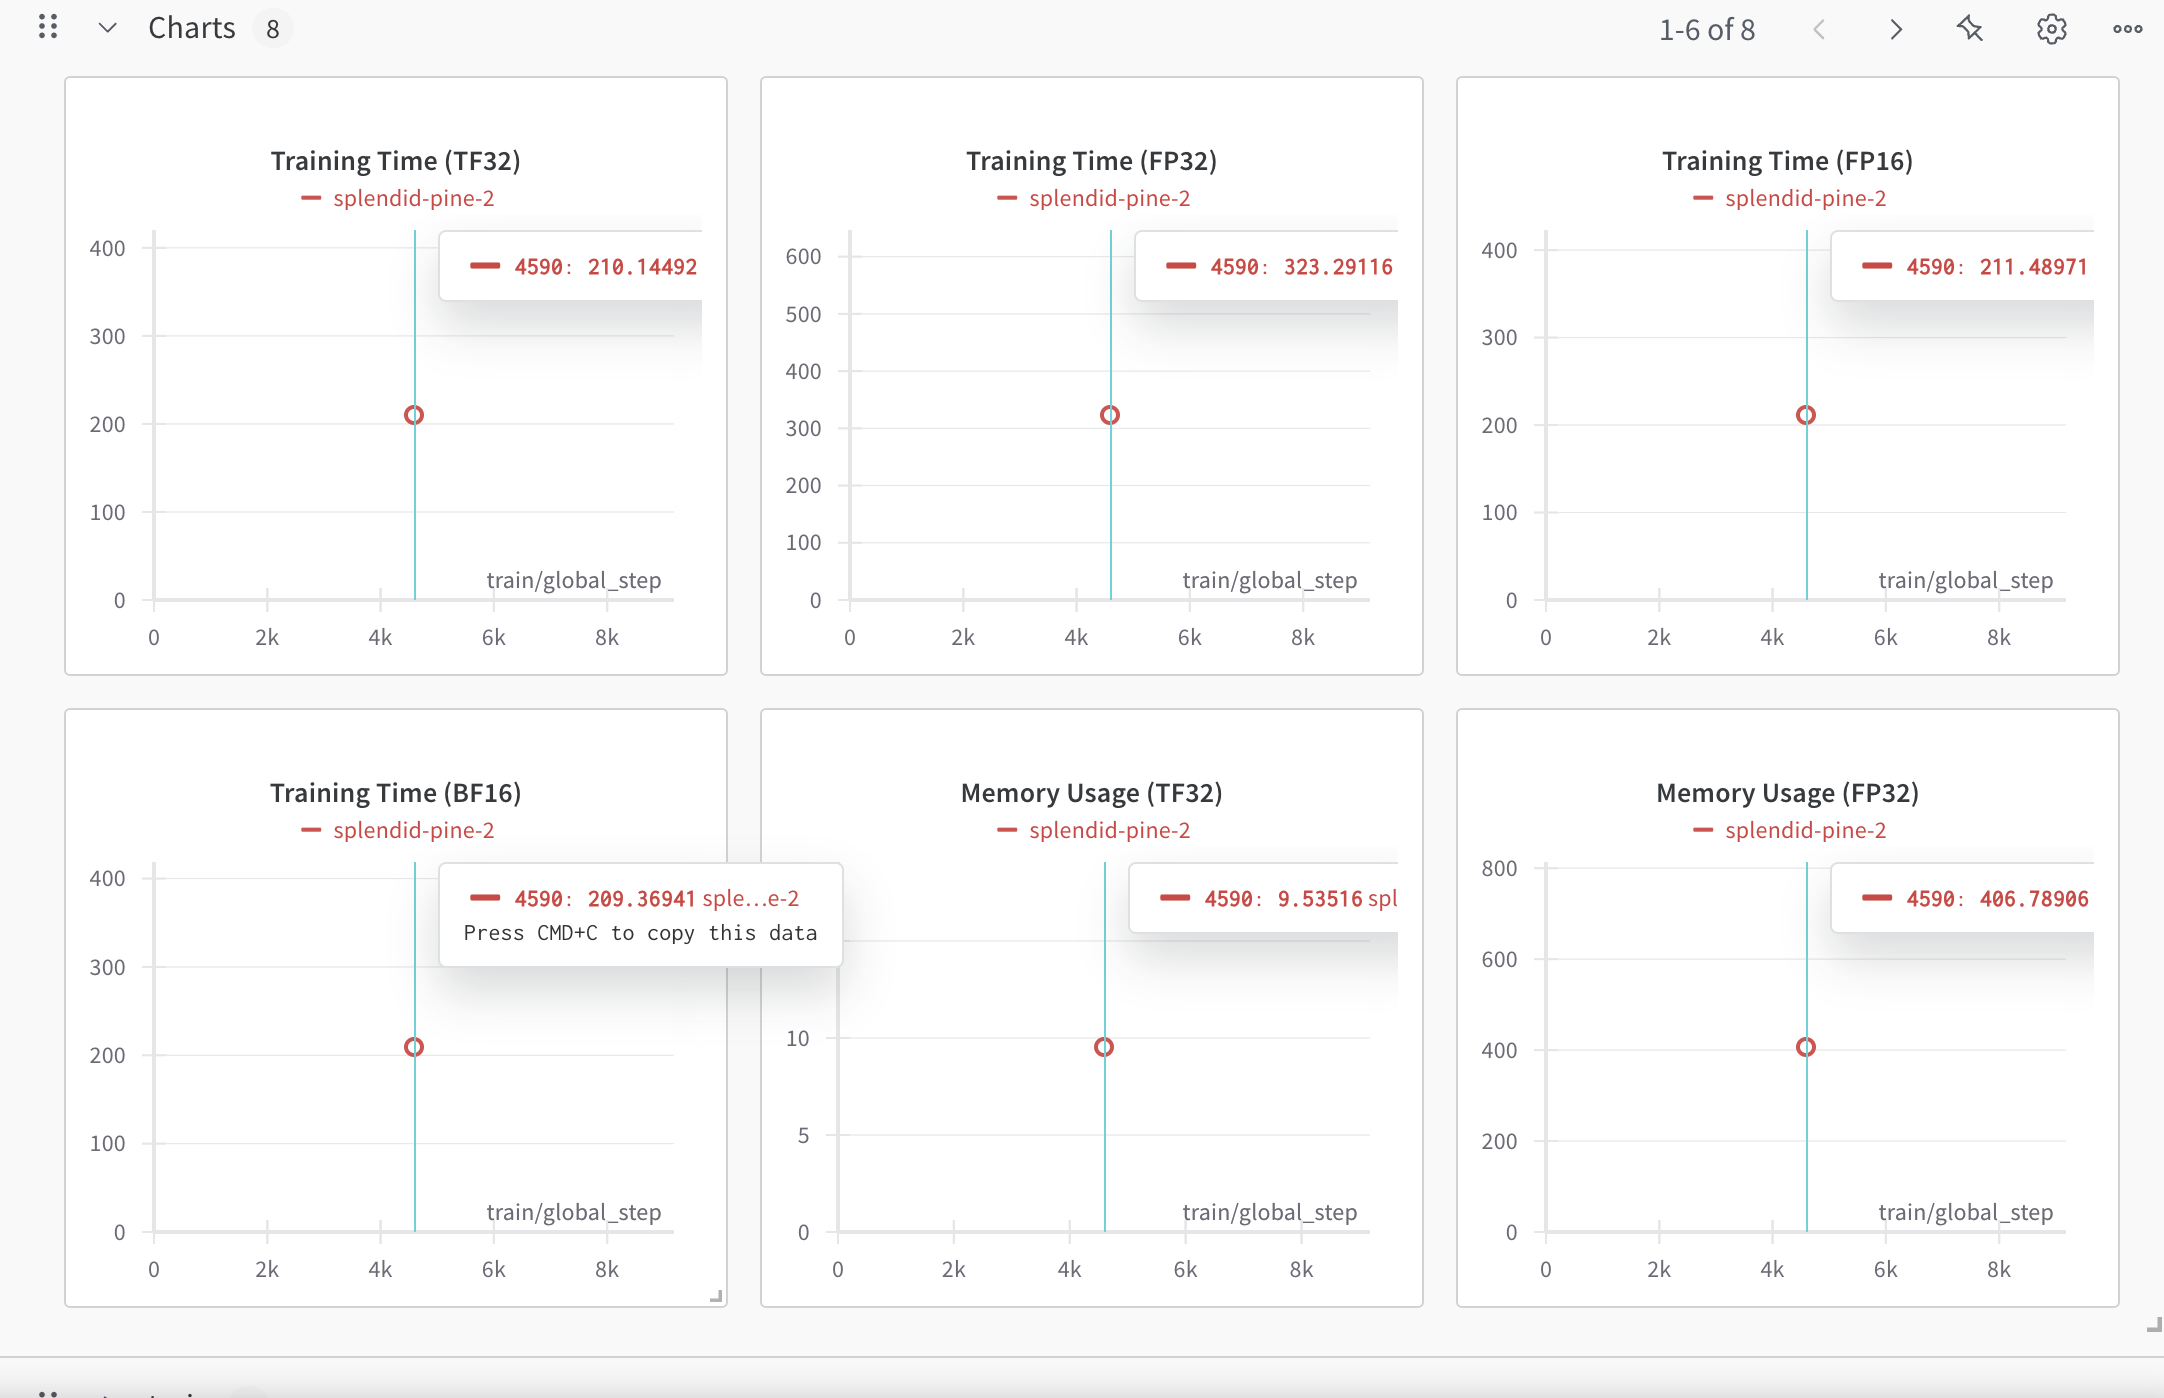